In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

In [2]:
#Load dataset
file_path1 = 'C:\\Users\\xinyi Luo\\Desktop\\Project01 Bank\\Lloyds_data.csv' 
df_lloyds = pd.read_csv(file_path1)

# EDA

In [3]:
# Group by department and count unique individual_ids
department_counts = df_lloyds.groupby('department')['individual_id'].nunique().reset_index()
department_counts.columns = ['Department', 'Number of Individuals']
department_counts

# Aggregate statistical features
# Group by employee ID to calculate the average spend, number of transactions, median, standard deviation, max, min for each employee
agg_features = df_lloyds.groupby('individual_id')['spend'].agg(['mean', 'count', 'median', 'std', 'max', 'min']).reset_index()
agg_features.columns = ['individual_id', 'mean_spend', 'count_spend', 'median_spend', 'std_spend', 'max_spend', 'min_spend']
agg_features


,individual_id,mean_spend,count_spend,median_spend,std_spend,max_spend,min_spend
0,1,6.895769,104,4.060,11.636417,110.06,0.10
1,2,10.878000,15,6.580,17.306564,69.20,0.09
2,3,6.037419,31,4.330,5.034086,17.97,0.60
3,4,6.188983,59,4.280,5.719570,24.99,0.03
4,5,3.875000,2,3.875,2.609224,5.72,2.03
...,...,...,...,...,...,...,...
2180,2181,4.420833,12,2.515,4.714067,15.25,0.52
2181,2182,6.268559,236,3.625,7.725172,62.81,0.00
2182,2183,6.904167,12,3.705,6.678988,18.72,0.01
2183,2184,6.955250,80,4.600,6.298992,29.06,0.15


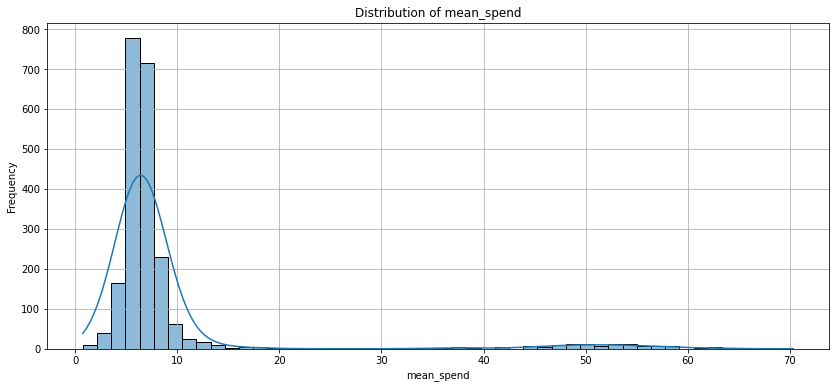

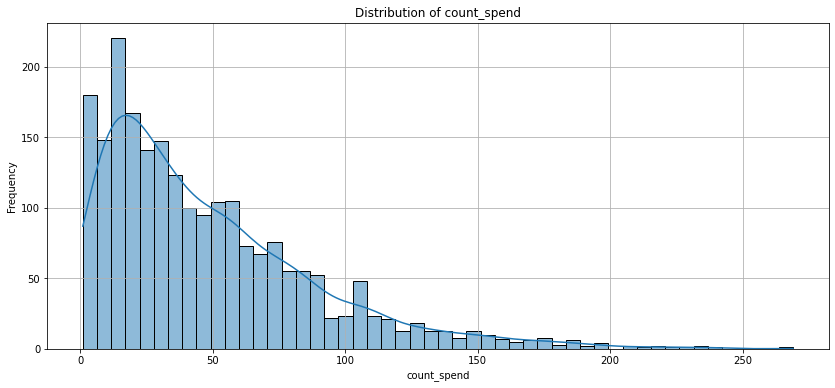

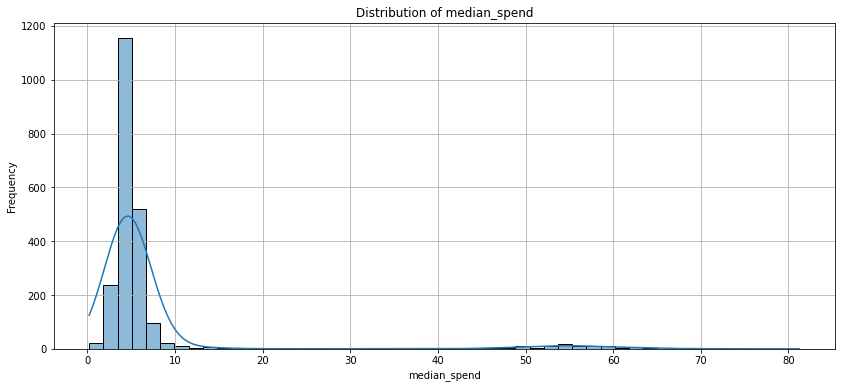

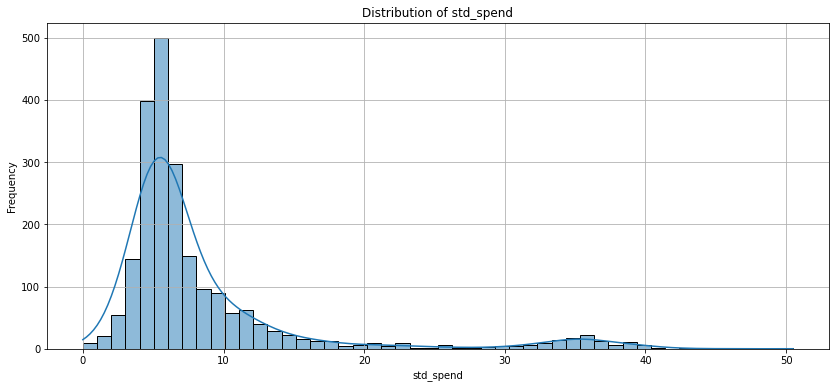

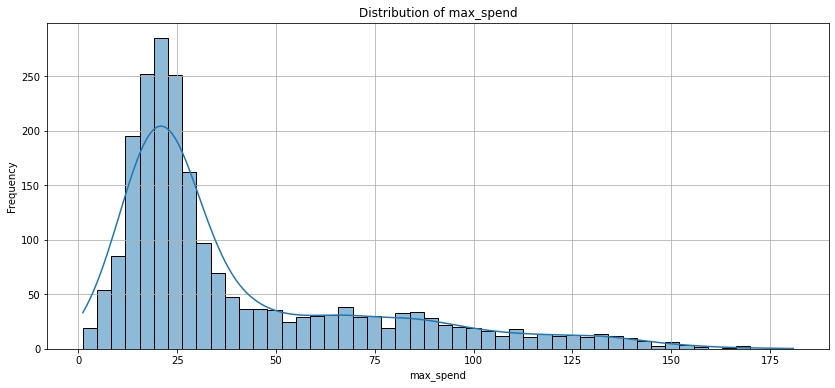

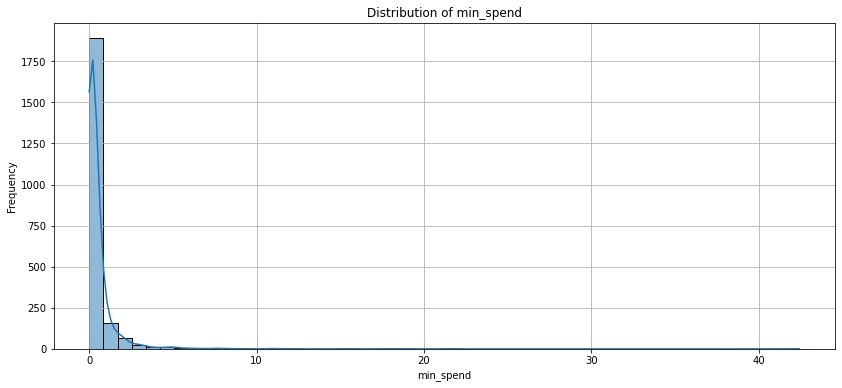

In [5]:
# Plot histogram and density plot for each feature
features = ['mean_spend', 'count_spend', 'median_spend', 'std_spend', 'max_spend', 'min_spend']

for feature in features:
    plt.figure(figsize=(14, 6))
    sns.histplot(agg_features[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [4]:
# Frequency features
# Calculate the frequency of each employee's actions within different time periods

# Convert date to datetime format and extract week, day, and hour information
df_lloyds['date'] = pd.to_datetime(df_lloyds['date'], format='%d/%m/%Y')
df_lloyds['week'] = df_lloyds['date'].dt.isocalendar().week
df_lloyds['day'] = df_lloyds['date'].dt.day_name()
df_lloyds['hour'] = df_lloyds['hour_of_day'].apply(lambda x: int(x)) # Convert 'hour_of_day' to integer

# Calculate the frequency
weekly_freq = df_lloyds.groupby(['individual_id', 'week']).size().reset_index(name='weekly_transactions')
daily_freq = df_lloyds.groupby(['individual_id', 'day']).size().reset_index(name='daily_transactions')
hourly_freq = df_lloyds.groupby(['individual_id', 'hour']).size().reset_index(name='hourly_transactions')

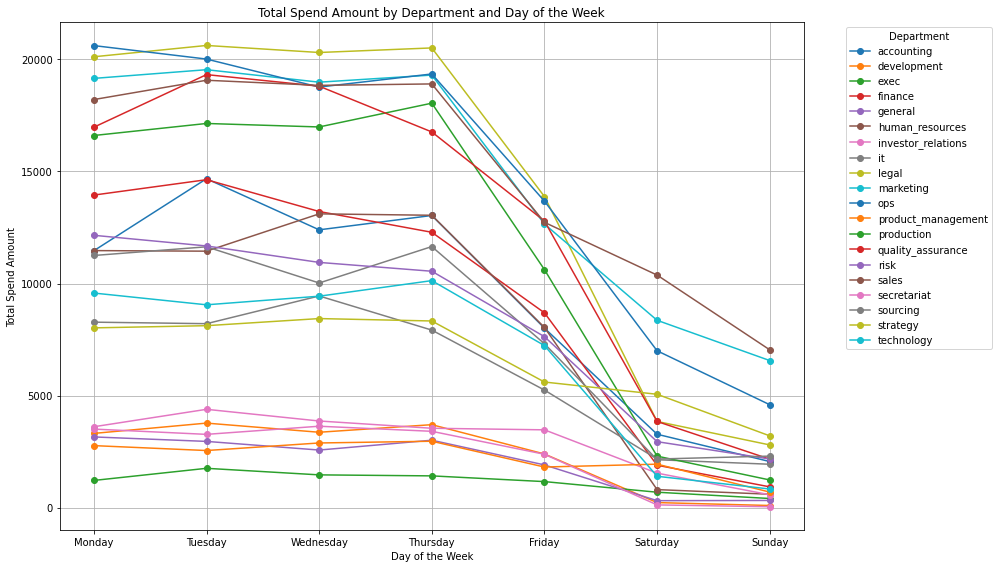

In [6]:
# Total transaction amount per department for each day of the week

# Create a pivot table for the spend amount per department by day of the week
dept_day_spend = df_lloyds.pivot_table(index='department', columns='day', values='spend', aggfunc='sum').fillna(0)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dept_day_spend = dept_day_spend[day_order]
dept_day_spend.reset_index(inplace=True) # Reset index to make 'department' a column again

# Plot the total transaction amount per department for each day of the week
plt.figure(figsize=(14, 8))
for department in dept_day_spend['department']:
    # Plot each department's total spend amount by day
    plt.plot(day_order, dept_day_spend[dept_day_spend['department'] == department][day_order].values.flatten(), marker='o', label=department)

# Add title and labels to the plot
plt.title('Total Spend Amount by Department and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Spend Amount')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()


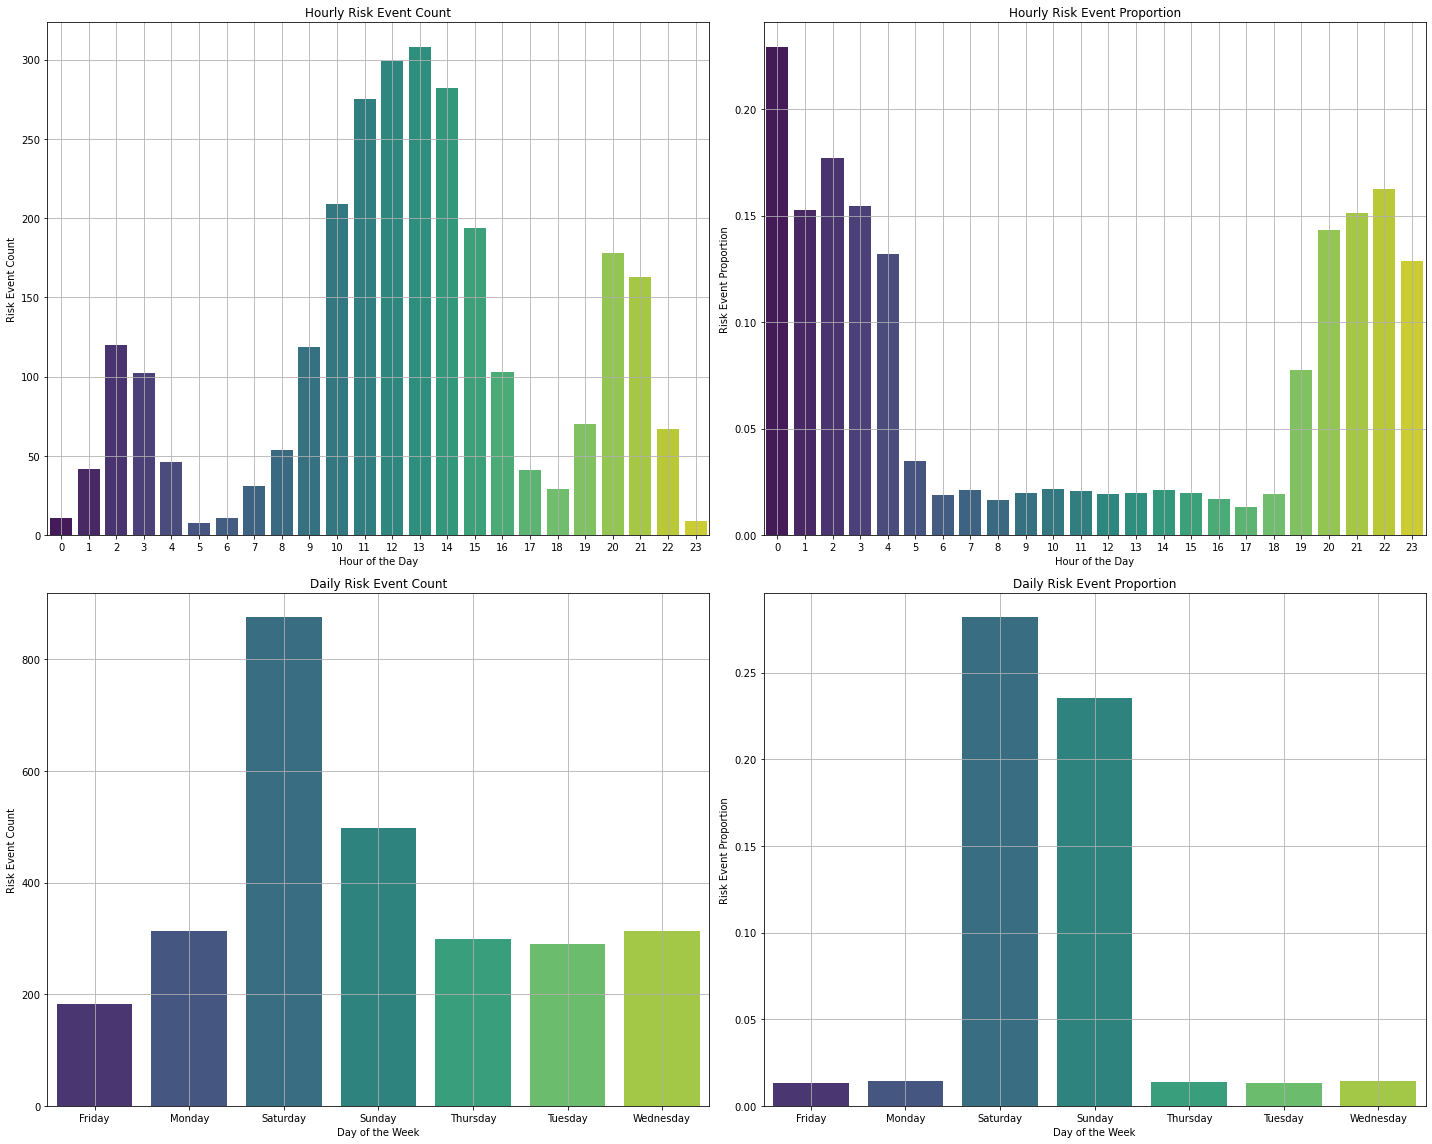

In [7]:
# Calculate total transaction volume and risk transaction volume per hour/day
total_hourly_events = df_lloyds.groupby('hour')['at_risk_event'].count().reset_index()
total_hourly_events.columns = ['hour', 'total_event_count']
hourly_risk_events = df_lloyds[df_lloyds['at_risk_event'] == True].groupby('hour')['at_risk_event'].count().reset_index()
hourly_risk_events.columns = ['hour', 'risk_event_count']

total_daily_events = df_lloyds.groupby('day_of_week')['at_risk_event'].count().reset_index()
total_daily_events.columns = ['day_of_week', 'total_event_count']
daily_risk_events = df_lloyds[df_lloyds['at_risk_event'] == True].groupby('day_of_week')['at_risk_event'].count().reset_index()
daily_risk_events.columns = ['day_of_week', 'risk_event_count']

# Calculate the proportion of risk transactions
hourly_events = pd.merge(total_hourly_events, hourly_risk_events, on='hour', how='left').fillna(0)
hourly_events['risk_event_proportion'] = hourly_events['risk_event_count'] / hourly_events['total_event_count']
daily_events = pd.merge(total_daily_events, daily_risk_events, on='day_of_week', how='left').fillna(0)
daily_events['risk_event_proportion'] = daily_events['risk_event_count'] / daily_events['total_event_count']


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
# First subplot: Hourly risk event count
sns.barplot(data=hourly_risk_events, x='hour', y='risk_event_count', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Hourly Risk Event Count')
axes[0, 0].set_xlabel('Hour of the Day')
axes[0, 0].set_ylabel('Risk Event Count')
axes[0, 0].grid(True)
# Second subplot: Hourly risk event proportion
sns.barplot(data=hourly_events, x='hour', y='risk_event_proportion', palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Hourly Risk Event Proportion')
axes[0, 1].set_xlabel('Hour of the Day')
axes[0, 1].set_ylabel('Risk Event Proportion')
axes[0, 1].grid(True)

# Third subplot: Daily risk event count
sns.barplot(data=daily_risk_events, x='day_of_week', y='risk_event_count', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Daily Risk Event Count')
axes[1, 0].set_xlabel('Day of the Week')
axes[1, 0].set_ylabel('Risk Event Count')
axes[1, 0].grid(True)

# Fourth subplot: Daily risk event proportion
sns.barplot(data=daily_events, x='day_of_week', y='risk_event_proportion', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Daily Risk Event Proportion')
axes[1, 1].set_xlabel('Day of the Week')
axes[1, 1].set_ylabel('Risk Event Proportion')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### Issue: Distinguishing Anomalies from Risks
Analysing typical historical patterns of behaviour (rate of behavioural change, differences between current and historical behaviour, e.g. current transaction amounts versus historical average transaction amounts)

In [8]:
# Adding time features and behavior change rate features
# mean_spend_all_time: Represents the average spend amount of each employee over all time periods. Helps identify unusual high or low spending behavior.
# std_spend_all_time: The standard deviation measures the volatility of spending amounts. High volatility may indicate potential risk.
# non_office_hour_activity_ratio: The proportion of an employee's activity on non_office_hour. Helps identify employees who suddenly become active on weekends/midnight,etc.

# Add hour and non_office_hour features
df_lloyds['hour'] = df_lloyds['hour_of_day'].apply(lambda x: int(x))
df_lloyds['not_office_hour'] = df_lloyds.apply(
    lambda row: 0 if row['day_of_week'] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] and 8 <= row['hour'] <= 18 else 1, axis=1)

# Calculate behavior change features
behavior_change_features = df_lloyds.groupby('individual_id').agg({
    'spend': ['mean', 'std', 'median'],
    'not_office_hour': 'mean'
}).reset_index()
behavior_change_features.columns = ['individual_id', 'mean_spend_all_time', 'std_spend_all_time', 'median_spend_all_time', 'non_office_hour_activity_ratio']

# Calculate average transaction amount during office and non-office hours
# Calculate total and average spend as well as transaction count during office/non-office hours
office_hour_spend = df_lloyds[df_lloyds['not_office_hour'] == 0].groupby('individual_id')['spend'].agg(['sum', 'mean', 'count']).reset_index()
office_hour_spend.columns = ['individual_id', 'total_spend_office_hour', 'mean_spend_office_hour', 'count_office_hour']
non_office_hour_spend = df_lloyds[df_lloyds['not_office_hour'] == 1].groupby('individual_id')['spend'].agg(['sum', 'mean', 'count']).reset_index()
non_office_hour_spend.columns = ['individual_id', 'total_spend_non_office_hour', 'mean_spend_non_office_hour', 'count_non_office_hour']

# Merge office and non-office hour spend features
behavior_change_features = behavior_change_features.merge(office_hour_spend, on='individual_id', how='left')
behavior_change_features = behavior_change_features.merge(non_office_hour_spend, on='individual_id', how='left')

# Fill missing values for employees who did not transact during certain periods
behavior_change_features[['total_spend_office_hour', 'mean_spend_office_hour', 'count_office_hour', 'total_spend_non_office_hour', 'mean_spend_non_office_hour', 'count_non_office_hour']] = \
    behavior_change_features[['total_spend_office_hour', 'mean_spend_office_hour', 'count_office_hour', 'total_spend_non_office_hour', 'mean_spend_non_office_hour', 'count_non_office_hour']].fillna(0)

behavior_change_features

,individual_id,mean_spend_all_time,std_spend_all_time,median_spend_all_time,non_office_hour_activity_ratio,total_spend_office_hour,mean_spend_office_hour,count_office_hour,total_spend_non_office_hour,mean_spend_non_office_hour,count_non_office_hour
0,1,6.895769,11.636417,4.060,0.057692,694.63,7.088061,98.0,22.53,3.755000,6.0
1,2,10.878000,17.306564,6.580,0.133333,149.91,11.531538,13.0,13.26,6.630000,2.0
2,3,6.037419,5.034086,4.330,0.000000,187.16,6.037419,31.0,0.00,0.000000,0.0
3,4,6.188983,5.719570,4.280,0.254237,304.47,6.919773,44.0,60.68,4.045333,15.0
4,5,3.875000,2.609224,3.875,0.000000,7.75,3.875000,2.0,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2180,2181,4.420833,4.714067,2.515,0.000000,53.05,4.420833,12.0,0.00,0.000000,0.0
2181,2182,6.268559,7.725172,3.625,0.588983,500.81,5.162990,97.0,978.57,7.040072,139.0
2182,2183,6.904167,6.678988,3.705,0.000000,82.85,6.904167,12.0,0.00,0.000000,0.0
2183,2184,6.955250,6.298992,4.600,0.062500,506.24,6.749867,75.0,50.18,10.036000,5.0


In [9]:
# Calculate at_risk_event ratios
# Calculate the count of at-risk events /total for each individual
at_risk_events = df_lloyds[df_lloyds['at_risk_event'] == 1].groupby('individual_id').size().reset_index(name='at_risk_event_count')
total_events = df_lloyds.groupby('individual_id').size().reset_index(name='total_event_count')

# Calculate the ratio of at-risk events to total events
event_ratios = at_risk_events.merge(total_events, on='individual_id')
event_ratios['at_risk_event_ratio'] = event_ratios['at_risk_event_count'] / event_ratios['total_event_count']
# Merge the calculated ratios with the department information
event_ratios = event_ratios.merge(df_lloyds[['individual_id', 'department']].drop_duplicates(), on='individual_id')

# Calculate department-wise average at_risk_event ratio
# Calculate the average at-risk event ratio for each department
department_risk_ratio = event_ratios.groupby('department')['at_risk_event_ratio'].mean().reset_index()
department_risk_ratio.columns = ['department', 'avg_at_risk_event_ratio']

# Merge individual behavior change features with their respective departments
merged_data = df_lloyds[['individual_id', 'department']].drop_duplicates().merge(behavior_change_features, on='individual_id')
# The final_data DataFrame now contains individual behavior features and department-wise average risk ratios
final_data = merged_data.merge(department_risk_ratio, on='department', how='left')
final_data


,individual_id,department,mean_spend_all_time,std_spend_all_time,median_spend_all_time,non_office_hour_activity_ratio,total_spend_office_hour,mean_spend_office_hour,count_office_hour,total_spend_non_office_hour,mean_spend_non_office_hour,count_non_office_hour,avg_at_risk_event_ratio
0,1,ops,6.895769,11.636417,4.060,0.057692,694.63,7.088061,98.0,22.53,3.755000,6.0,0.043242
1,2,finance,10.878000,17.306564,6.580,0.133333,149.91,11.531538,13.0,13.26,6.630000,2.0,0.054483
2,3,product_management,6.037419,5.034086,4.330,0.000000,187.16,6.037419,31.0,0.00,0.000000,0.0,0.022479
3,4,legal,6.188983,5.719570,4.280,0.254237,304.47,6.919773,44.0,60.68,4.045333,15.0,0.046383
4,5,risk,3.875000,2.609224,3.875,0.000000,7.75,3.875000,2.0,0.00,0.000000,0.0,0.053196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,2181,sourcing,4.420833,4.714067,2.515,0.000000,53.05,4.420833,12.0,0.00,0.000000,0.0,0.049576
2181,2182,sourcing,6.268559,7.725172,3.625,0.588983,500.81,5.162990,97.0,978.57,7.040072,139.0,0.049576
2182,2183,accounting,6.904167,6.678988,3.705,0.000000,82.85,6.904167,12.0,0.00,0.000000,0.0,0.053151
2183,2184,finance,6.955250,6.298992,4.600,0.062500,506.24,6.749867,75.0,50.18,10.036000,5.0,0.054483


In [12]:
# Group by department to calculate average transaction amounts and counts during office and non-office hours
department_spend = merged_data.groupby('department')[['total_spend_office_hour', 'mean_spend_office_hour', 'count_office_hour', 
                                                      'total_spend_non_office_hour', 'mean_spend_non_office_hour', 'count_non_office_hour']].mean().reset_index()

# Define a flag to indicate if a transaction occurred during office hours
df_lloyds['is_office_hour'] = df_lloyds.apply(
    lambda row: 1 if row['day_of_week'] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] and 8 <= row['hour'] <= 18 else 0, axis=1)

# Group by department and office hour flag to calculate the proportion of risk transactions
risk_ratio = df_lloyds.groupby(['department', 'is_office_hour'])['at_risk_event'].mean().reset_index()

# Separate risk ratios for office and non-office hours by pivoting the table
risk_ratio_pivot = risk_ratio.pivot(index='department', columns='is_office_hour', values='at_risk_event').fillna(0)
risk_ratio_pivot.columns = ['Non-Office Hour Risk Ratio', 'Office Hour Risk Ratio']

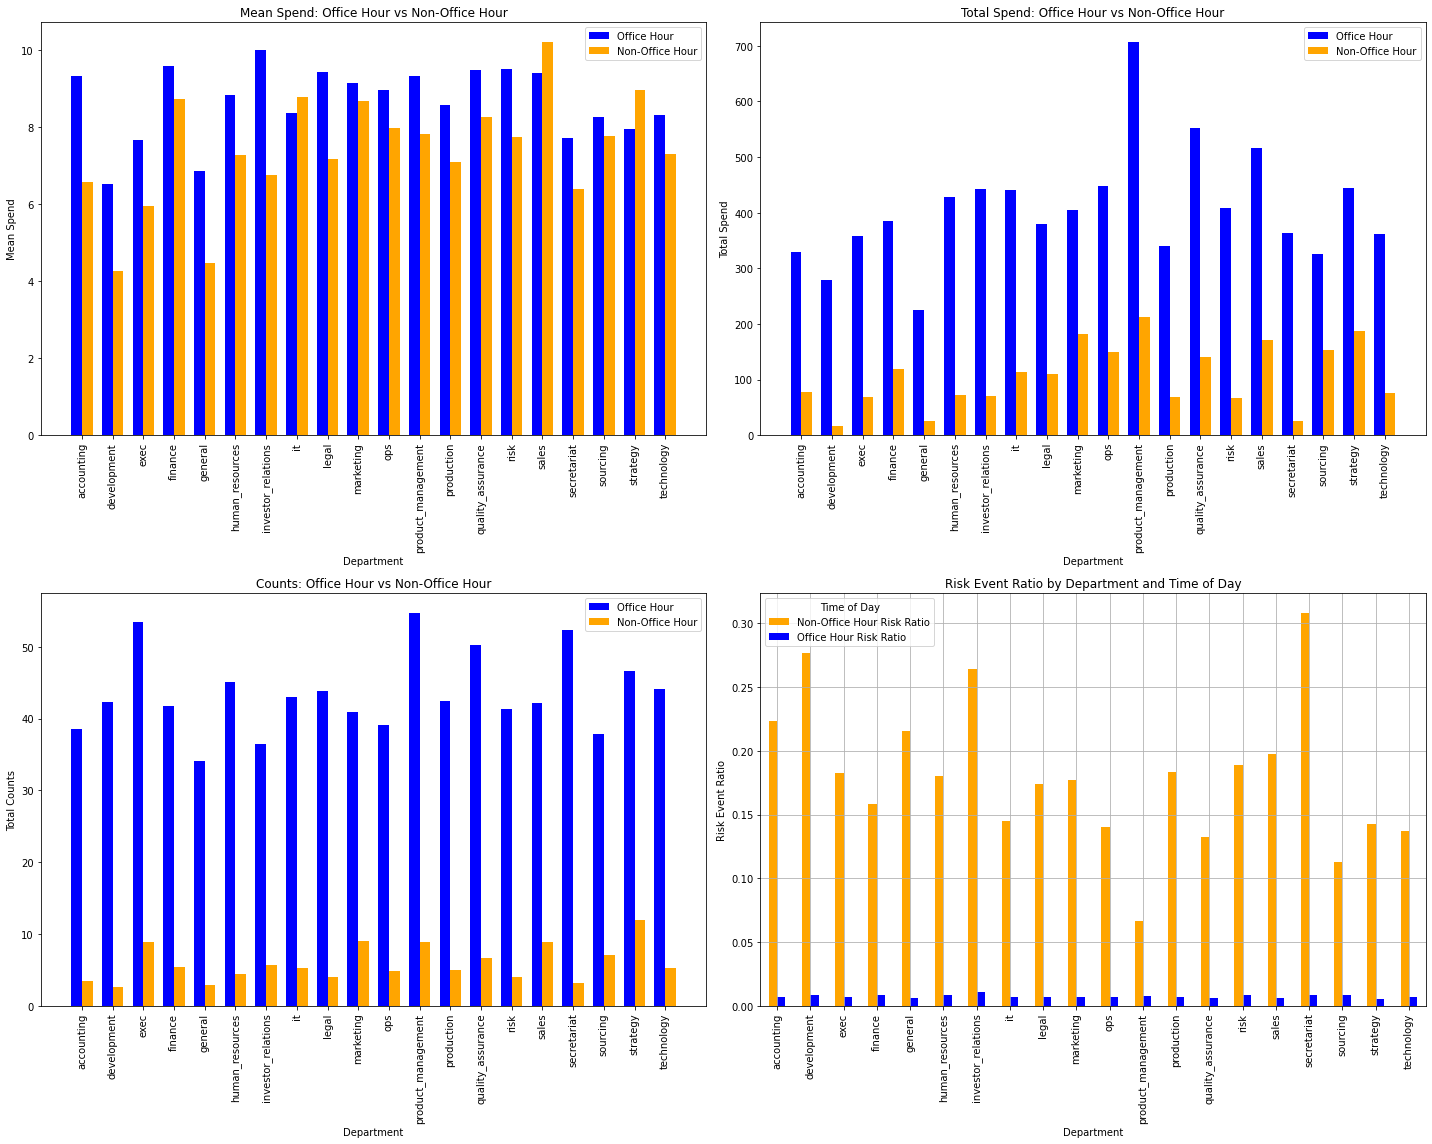

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))

# Subplot 1: Visualize average spend during office and non-office hours
bar_width = 0.35
index = np.arange(len(department_spend))  # Ensure index is numeric for addition operations

# Plot average spend during office hours/non-office hours
axes[0, 0].bar(index, department_spend['mean_spend_office_hour'], bar_width, label='Office Hour', color='blue')
axes[0, 0].bar(index + bar_width, department_spend['mean_spend_non_office_hour'], bar_width, label='Non-Office Hour', color='orange')

# Set labels and title for the first subplot
axes[0, 0].set_xlabel('Department')
axes[0, 0].set_ylabel('Mean Spend')
axes[0, 0].set_title('Mean Spend: Office Hour vs Non-Office Hour')
axes[0, 0].set_xticks(index + bar_width / 2)
axes[0, 0].set_xticklabels(department_spend['department'], rotation=90)
axes[0, 0].legend()

# Subplot 2: Visualize total spend during office and non-office hours
# Plot total spend during office/non-office hours
axes[0, 1].bar(index, department_spend['total_spend_office_hour'], bar_width, label='Office Hour', color='blue')
axes[0, 1].bar(index + bar_width, department_spend['total_spend_non_office_hour'], bar_width, label='Non-Office Hour', color='orange')

# Set labels and title
axes[0, 1].set_xlabel('Department')
axes[0, 1].set_ylabel('Total Spend')
axes[0, 1].set_title('Total Spend: Office Hour vs Non-Office Hour')
axes[0, 1].set_xticks(index + bar_width / 2)
axes[0, 1].set_xticklabels(department_spend['department'], rotation=90)
axes[0, 1].legend()

# Subplot 3: Visualize total transaction counts during office and non-office hours
axes[1, 0].bar(index, department_spend['count_office_hour'], bar_width, label='Office Hour', color='blue')
axes[1, 0].bar(index + bar_width, department_spend['count_non_office_hour'], bar_width, label='Non-Office Hour', color='orange')

# Set labels and title
axes[1, 0].set_xlabel('Department')
axes[1, 0].set_ylabel('Total Counts')
axes[1, 0].set_title('Counts: Office Hour vs Non-Office Hour')
axes[1, 0].set_xticks(index + bar_width / 2)
axes[1, 0].set_xticklabels(department_spend['department'], rotation=90)
axes[1, 0].legend()

# Subplot 4: Visualize risk event ratio by department and time of day
risk_ratio_pivot.plot(kind='bar', ax=axes[1, 1], color=['orange', 'blue'])
axes[1, 1].set_title('Risk Event Ratio by Department and Time of Day')
axes[1, 1].set_xlabel('Department')
axes[1, 1].set_ylabel('Risk Event Ratio')
axes[1, 1].set_xticklabels(risk_ratio_pivot.index, rotation=90)
axes[1, 1].grid(True)
axes[1, 1].legend(title='Time of Day')


plt.tight_layout()
plt.show()

## Correlation/Clustering Analysis
Based on these three labels, we then cluster each person's spending history by combining the "department" in the original data with some aggregated statistical features (e.g., mean, median, etc.). However, it is required that the employees of the departments are not mixed, and that the employees of each department always stay in the same category.
Weighting the features: Before normalisation, the features are weighted using the weighting values.

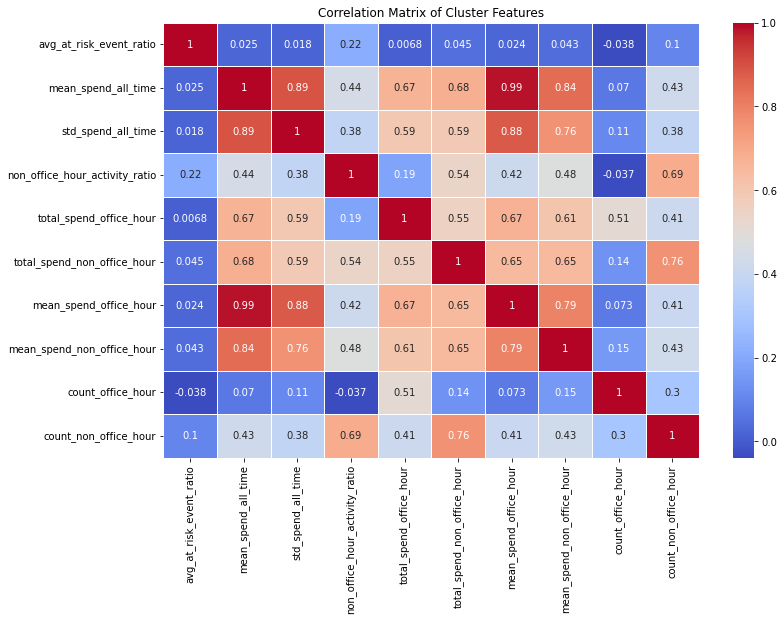

In [14]:
variables_of_interest = [
    'avg_at_risk_event_ratio',
    'mean_spend_all_time',
    'std_spend_all_time',
    #'median_spend_all_time',
    'non_office_hour_activity_ratio',
    'total_spend_office_hour',
    'total_spend_non_office_hour',
    'mean_spend_office_hour',
    'mean_spend_non_office_hour',
    'count_office_hour',
    'count_non_office_hour'
]

# Calculate the correlation matrix for the variables of interest
correlation_matrix = final_data[variables_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5) 
plt.title('Correlation Matrix of Cluster Features') 
plt.show()

In [15]:
# Calculate the number of employees in each department
department_counts = df_lloyds.groupby('department')['individual_id'].nunique().reset_index()
department_counts.rename(columns={'individual_id': 'employee_count'}, inplace=True)

# Calculate aggregate statistical features for each department
dept_features = merged_data.groupby('department').agg(
    mean_spend_all_time=('mean_spend_all_time', 'mean'),
    # median_spend_all_time=('median_spend_all_time','mean'),  
    std_spend_all_time=('std_spend_all_time', 'median'),
    non_office_hour_activity_ratio=('non_office_hour_activity_ratio', 'median'),
    # count_office_hour=('count_office_hour', 'mean'),  
    count_non_office_hour=('count_non_office_hour', 'median'),
    # total_spend_non_office_hour=('total_spend_non_office_hour', 'mean')  
).reset_index()
dept_features = dept_features.merge(department_counts, on='department', how='left')
dept_features.fillna(0, inplace=True)

# Define weights for each feature
feature_weights = {
    'mean_spend_all_time': 1.5,
    'std_spend_all_time': 0.5,
    'non_office_hour_activity_ratio': 1.5,
    # 'count_office_hour': 1.0,  
    'count_non_office_hour': 1.0,
    # 'total_spend_non_office_hour': 1.5, 
    'employee_count': 0.5  
}

# Adjust features based on defined weights
for feature, weight in feature_weights.items():
    if feature in dept_features.columns:
        dept_features[feature] *= weight

# Standardize the features
scaler = StandardScaler()
dept_features_scaled = scaler.fit_transform(dept_features.select_dtypes(include=[float, int]))

# Check for NaN values in the standardized data
# print("Check for NaN values in the standardized data:\n", pd.DataFrame(dept_features_scaled).isnull().sum())

In [16]:
# Apply K-Means clustering to the department features
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300, tol=1e-4)
dept_features['cluster'] = kmeans.fit_predict(dept_features_scaled)

# Apply the clustering results to each employee based on their department
df_lloyds = df_lloyds.merge(dept_features[['department', 'cluster']], on='department', how='left')

# View which departments' employees belong to each cluster and the volume of each cluster
departments_in_clusters = dept_features.groupby('cluster')['department'].unique().reset_index()
print(dept_features['cluster'].value_counts())
print(df_lloyds['cluster'].value_counts())
print(departments_in_clusters.to_string())

1    10
2     5
0     5
Name: cluster, dtype: int64
1    68348
0    23961
2    12968
Name: cluster, dtype: int64
   cluster                                                                                                     department
0        0                                                         [exec, investor_relations, marketing, sales, strategy]
1        1  [accounting, finance, human_resources, legal, ops, production, quality_assurance, risk, sourcing, technology]
2        2                                                    [development, general, it, product_management, secretariat]


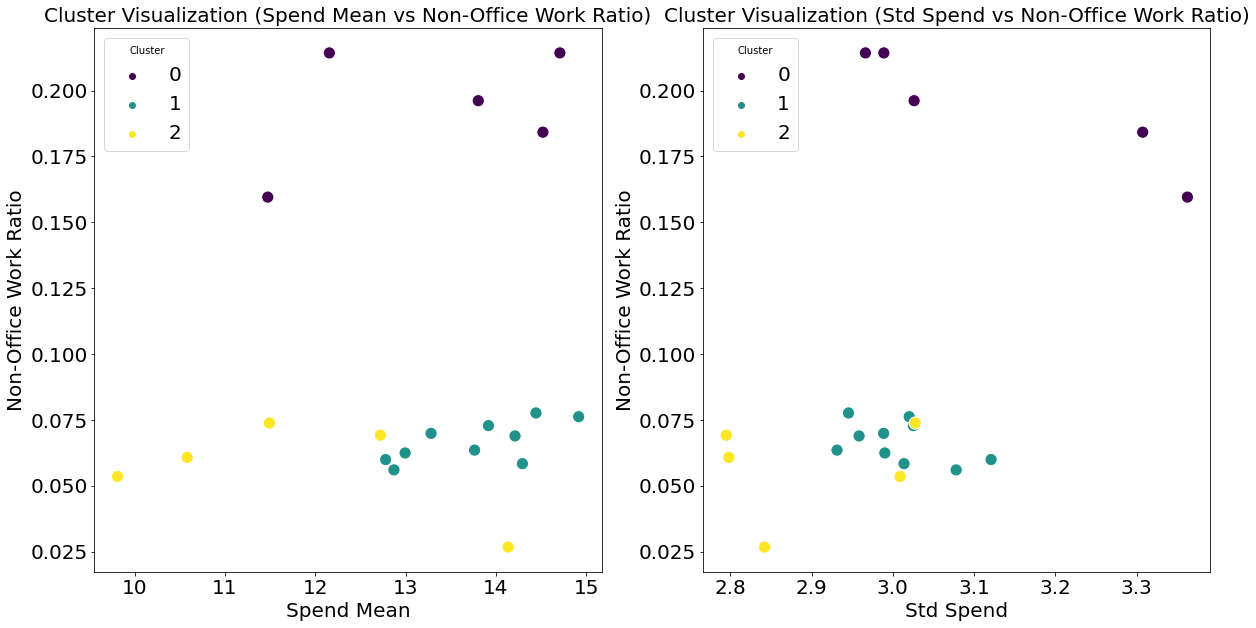

         mean_spend_all_time  std_spend_all_time  \
cluster                                            
0                  13.332276            3.130362   
1                  13.746699            3.007279   
2                  11.748473            2.894412   

         non_office_hour_activity_ratio  count_non_office_hour  employee_count  
cluster                                                                         
0                              0.193702                    5.1            46.5  
1                              0.066633                    1.6            72.3  
2                              0.056850                    1.6            27.4  


In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
label_fontsize = 20
scatter_size = 150 # Set size for labels/points in plots

# First subplot: mean_spend_all_time vs non_office_hour_activity_ratio
sns.scatterplot(
    ax=axs[0], 
    x='mean_spend_all_time', 
    y='non_office_hour_activity_ratio', 
    hue='cluster', 
    data=dept_features, 
    palette='viridis', 
    s=scatter_size
)
axs[0].set_title('Cluster Visualization (Spend Mean vs Non-Office Work Ratio)', fontsize=label_fontsize)
axs[0].set_xlabel('Spend Mean', fontsize=label_fontsize)
axs[0].set_ylabel('Non-Office Work Ratio', fontsize=label_fontsize)
axs[0].legend(title='Cluster', fontsize=label_fontsize)

# Second subplot: std_spend_all_time vs non_office_hour_activity_ratio
sns.scatterplot(
    ax=axs[1], 
    x='std_spend_all_time', 
    y='non_office_hour_activity_ratio', 
    hue='cluster', 
    data=dept_features, 
    palette='viridis', 
    s=scatter_size
)
axs[1].set_title('Cluster Visualization (Std Spend vs Non-Office Work Ratio)', fontsize=label_fontsize)
axs[1].set_xlabel('Std Spend', fontsize=label_fontsize)
axs[1].set_ylabel('Non-Office Work Ratio', fontsize=label_fontsize)
axs[1].legend(title='Cluster', fontsize=label_fontsize)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize) # Adjust font size for tick labels on both subplots
plt.show()

# View the feature distribution for each cluster
cluster_summary = dept_features.groupby('cluster').mean()
print(cluster_summary)

In [18]:
# Calculate the proportion of risk events for each category
# Convert 'at_risk_event' column to 'true_anomaly' column
df_lloyds['true_anomaly'] = df_lloyds['at_risk_event'].apply(lambda x: 1 if x == True else 0)

# Confirm the value distribution of the 'true_anomaly' column
print(df_lloyds['at_risk_event'].value_counts())
print(df_lloyds['true_anomaly'].value_counts())

# Group by 'cluster' and apply value_counts to the 'true_anomaly' column for each group
cluster_true_anomaly_distribution = df_lloyds.groupby('cluster')['true_anomaly'].value_counts().unstack().fillna(0)

# Print the result
print(cluster_true_anomaly_distribution)

False    102506
True       2771
Name: at_risk_event, dtype: int64
0    102506
1      2771
Name: true_anomaly, dtype: int64
true_anomaly      0     1
cluster                  
0             23058   903
1             66774  1574
2             12674   294


# Feature Engineering

### Label each record for whether it is on a weekend, whether it is out of hours and whether the amount exceeds the employee's daily behaviour threshold. Add three label columns
label transactions to identify anomalous spending patterns based on high spending amounts, weekend activity, and out-of-office-hours behavior, with dynamic adjustments using time windows.
High spending is identified when a transaction exceeds the 90th percentile of spending differences and marked as an anomaly. 
Weekend activity is flagged if transactions occur on weekends, but labels are reset for individuals with weekend transactions above the 90th percentile. 
Similarly, out-of-office-hour transactions are flagged but reset for frequent non-office-hour spenders. 
Time windows of 3 days (high spending and non-office hours) and 14 days (weekend activity) are used to adjust labels, avoiding over-labeling of regular behavior.

In [22]:
# Convert 'hour_of_day' to timedeltas and create a new 'datetime' column by combining 'date' and 'hour_of_day'
df_lloyds['date'] = pd.to_datetime(df_lloyds['date'], format='%d/%m/%Y')  # Adjust the date format as per the actual format in the data
df_lloyds['datetime'] = df_lloyds['date'] + pd.to_timedelta(df_lloyds['hour_of_day'], unit='h')

# Sort the DataFrame by 'individual_id' and 'datetime'
df_lloyds = df_lloyds.sort_values(by=['individual_id', 'datetime']).reset_index(drop=True)

In [19]:
# Define if the transaction is on a weekend
df_lloyds['is_in_weekend'] = df_lloyds['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

# Calculate the weekend work ratio for each employee
weekend_work_ratio = df_lloyds.groupby('individual_id')['is_in_weekend'].mean().reset_index()
weekend_work_ratio.columns = ['individual_id', 'weekend_ratio']

# Calculate the 90th percentile of the weekend work ratio
weekend_work_threshold = weekend_work_ratio['weekend_ratio'].quantile(0.90)

# Identify employees who frequently work on weekends
frequent_weekend_workers = weekend_work_ratio[weekend_work_ratio['weekend_ratio'] > weekend_work_threshold]['individual_id']

# Update weekend work flag for frequent weekend workers
df_lloyds.loc[df_lloyds['individual_id'].isin(frequent_weekend_workers) & (df_lloyds['is_in_weekend'] == 1), 'is_in_weekend'] = 0

# Define a time window of 14 days (14*24 hours) for adjusting the weekend work flag
window_size_weekend = 14 * 24  # 14 days time window in hours

# Adjust the weekend work flag based on the 14-day window
for individual in df_lloyds['individual_id'].unique():
    individual_data = df_lloyds[df_lloyds['individual_id'] == individual].reset_index(drop=True)
    for i in range(window_size_weekend, len(individual_data)):
        if individual_data.at[i, 'is_in_weekend'] == 1:
            previous_window = individual_data.loc[i-window_size_weekend:i-1, 'is_in_weekend']
            if previous_window.sum() > 0:
                df_lloyds.at[individual_data.index[i], 'is_in_weekend'] = 0

In [20]:
# Define if the transaction is outside of office hours
df_lloyds['is_out_office_hour'] = ((df_lloyds['hour_of_day'] < 8) | (df_lloyds['hour_of_day'] > 18)).astype(int)

# Calculate the ratio of non-office hour activities for each employee
non_office_hour_ratio = df_lloyds.groupby('individual_id')['is_out_office_hour'].mean().reset_index()
non_office_hour_ratio.columns = ['individual_id', 'non_office_hour_activity_ratio']

# Calculate the 90th percentile of the non-office hour activity ratio
non_office_hour_threshold = non_office_hour_ratio['non_office_hour_activity_ratio'].quantile(0.90)

# Identify employees who frequently work outside office hours
frequent_non_office_hour_workers = non_office_hour_ratio[non_office_hour_ratio['non_office_hour_activity_ratio'] > non_office_hour_threshold]['individual_id']

# Update non-office hour work flag for frequent non-office hour workers
df_lloyds.loc[df_lloyds['individual_id'].isin(frequent_non_office_hour_workers) & (df_lloyds['is_out_office_hour'] == 1), 'is_out_office_hour'] = 0

# Define a time window of 72 hours (3 days) for adjusting the non-office hour work flag
window_size_office_hour = 3 * 24  # 3 days time window in hours

# Adjust the non-office hour work flag based on the 3-day window
for individual in df_lloyds['individual_id'].unique():
    individual_data = df_lloyds[df_lloyds['individual_id'] == individual].reset_index(drop=True)
    for i in range(window_size_office_hour, len(individual_data)):
        if individual_data.at[i, 'is_out_office_hour'] == 1:
            previous_window = individual_data.loc[i-window_size_office_hour:i-1, 'is_out_office_hour']
            if previous_window.sum() > 0:
                df_lloyds.at[individual_data.index[i], 'is_out_office_hour'] = 0


In [23]:
# Set high spend threshold at the 90th percentile of the spend distribution
high_spend_threshold = df_lloyds['spend'].quantile(0.90)

# Mark transactions that exceed the high spend threshold
df_lloyds['is_high_spend'] = (df_lloyds['spend'] > high_spend_threshold).astype(int)

# Calculate the absolute difference in spend for each employee's consecutive transactions
df_lloyds['spend_diff'] = df_lloyds.groupby('individual_id')['spend'].diff().abs()

# Calculate the interval between high spend transactions
df_lloyds['high_spend_diff'] = df_lloyds.groupby('individual_id')['datetime'].diff().fillna(pd.Timedelta(seconds=0))

# Retain only the intervals of high spend transactions
high_spend_intervals = df_lloyds[df_lloyds['is_high_spend'] == 1].groupby('individual_id')['high_spend_diff'].mean()

# Calculate the average interval of high spend transactions for all employees
window_size_high_spend = int(high_spend_intervals.mean().total_seconds() // 3600)  # Convert to hours

# Print the calculated window size
print(f"The determined spend time window length is: {window_size_high_spend} hours")

# Adjust high spend markers based on the new time window length
for individual in df_lloyds['individual_id'].unique():
    individual_data = df_lloyds[df_lloyds['individual_id'] == individual].reset_index(drop=True)
    for i in range(window_size_high_spend, len(individual_data)):
        if individual_data.at[i, 'is_high_spend'] == 1:
            previous_window = individual_data.loc[i-window_size_high_spend:i-1, 'is_high_spend']
            if previous_window.sum() > 0:
                df_lloyds.at[individual_data.index[i], 'is_high_spend'] = 0


The determined spend time window length is: 72 hours


In [24]:
df_lloyds[['individual_id', 'datetime', 'spend','at_risk_event', 'is_in_weekend', 'is_out_office_hour', 'is_high_spend']].head(10)

,individual_id,datetime,spend,at_risk_event,is_in_weekend,is_out_office_hour,is_high_spend
0,1,2023-01-09 11:59:39.976656000,2.10,False,0,0,0
1,1,2023-01-11 09:10:02.860388400,4.45,False,0,0,0
2,1,2023-01-12 08:51:48.678962400,3.94,False,0,0,0
3,1,2023-01-12 10:44:15.049068000,2.72,False,0,0,0
4,1,2023-01-12 13:30:58.948632000,1.50,False,0,0,0
5,1,2023-01-13 09:32:11.128927200,3.02,False,0,0,0
6,1,2023-01-15 15:13:59.487204000,8.14,True,1,0,0
7,1,2023-01-16 13:58:00.850476000,2.39,False,0,0,0
8,1,2023-01-17 09:15:53.338334400,9.22,False,0,0,0
9,1,2023-01-18 12:53:02.008284000,8.22,False,0,0,0


# IF- traverses contamination results and calculates global performance 
Define the range of contamination values (0.01 to 0.05) to be tested.
Iterate over each cluster to evaluate the IsolationForest model within each cluster.
Train the IsolationForest model with each contamination value.
 --Predict outliers on the test set and convert predictions to binary format.
Combine the results from all clusters and calculate global F1 score, recall, and precision.

In [29]:
# Define if the transaction is on a weekend/outside office hours (for individual records)
df_lloyds['is_in_weekend_indi'] = df_lloyds['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df_lloyds['Non_office_hour_indi'] = ((df_lloyds['hour_of_day'] < 8) | (df_lloyds['hour_of_day'] > 18)).astype(int)

# Define the feature columns for modeling
features = ['spend', 'is_in_weekend', 'is_out_office_hour', 'is_high_spend', 'Non_office_hour_indi', 'is_in_weekend_indi']

In [35]:
# Define the range for contamination parameter
contamination_range = np.arange(0.01, 0.06, 0.01)

# Define a custom F1 score function
def custom_f1_score(y_true, y_pred):
    # Convert prediction results to 0 and 1
    # In IsolationForest, -1 indicates an anomaly (outlier), so we map -1 to 1 and 1 to 0
    y_pred = np.where(y_pred == -1, 1, 0)
    # Calculate and return the F1 score
    return f1_score(y_true, y_pred, pos_label=1)
f1_scorer = make_scorer(custom_f1_score, greater_is_better=True)

n_clusters = 3  # Number of clusters as determined by previous clustering results

results_IF = []
best_results = {}

# Iterate over each cluster and each contamination parameter
for cluster in range(n_clusters):
    # Select the subset of data belonging to the current cluster
    cluster_data = df_lloyds[df_lloyds['cluster'] == cluster]

    # Feature data
    X = cluster_data[features]
    y = cluster_data['true_anomaly']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    best_test_f1 = 0
    best_result = None

    for contamination in contamination_range:
        # Define and train the IsolationForest model
        clf = IsolationForest(contamination=contamination, random_state=42)
        clf.fit(X_train)

        # Predict on the validation set
        test_outliers = clf.predict(X_test)
        test_outliers = np.where(test_outliers == -1, 1, 0)  # Convert -1 to 1 (outliers) and 1 to 0 (inliers)

        # Calculate performance metrics on the validation set
        test_f1 = f1_score(y_test, test_outliers, pos_label=1)
        test_recall = recall_score(y_test, test_outliers, pos_label=1)
        test_precision = precision_score(y_test, test_outliers, pos_label=1)
        cm = confusion_matrix(y_test, test_outliers, labels=[1, 0])

        result = {
            'cluster': f'Cluster {cluster}',
            'contamination': contamination,
            'test_f1_score': test_f1,
            'test_recall': test_recall,
            'test_precision': test_precision,
            'confusion_matrix': cm,
            'y_test': y_test,
            'test_outliers': test_outliers
        }

        results_IF.append(result)

        # Check if this is the best parameter combination for the current cluster
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            best_result = result

    best_results[cluster] = best_result

# Global performance evaluation based on the best parameters for each cluster
all_true_IF = []
all_pred_IF = []

for cluster in range(n_clusters):
    best_result = best_results[cluster]
    all_true_IF.extend(best_result['y_test'])
    all_pred_IF.extend(best_result['test_outliers'])

# Print global performance evaluation
global_f1 = f1_score(all_true_IF, all_pred_IF, pos_label=1)
global_recall = recall_score(all_true_IF, all_pred_IF, pos_label=1)
global_precision = precision_score(all_true_IF, all_pred_IF, pos_label=1)

print("Global F1 Score:", global_f1)
print("Global Recall:", global_recall)
print("Global Precision:", global_precision)

results_df_IF = pd.DataFrame(results_IF)

Global F1 Score: 0.3463143254520167
Global Recall: 0.3010882708585248
Global Precision: 0.4075286415711948


In [36]:
results_df_IF.head(10)

,cluster,contamination,test_f1_score,test_recall,test_precision,confusion_matrix,y_test,test_outliers
0,Cluster 0,0.01,0.146893,0.098113,0.292135,"[[26, 239], [63, 6861]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cluster 0,0.02,0.182716,0.139623,0.264286,"[[37, 228], [103, 6821]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Cluster 0,0.03,0.173729,0.154717,0.198068,"[[41, 224], [166, 6758]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cluster 0,0.04,0.173258,0.173585,0.172932,"[[46, 219], [220, 6704]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Cluster 0,0.05,0.153846,0.173585,0.138138,"[[46, 219], [287, 6637]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Cluster 1,0.01,0.230088,0.165957,0.375000,"[[78, 392], [130, 19905]]",72858 0 78349 0 97398 0 63384 0 26...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Cluster 1,0.02,0.399538,0.368085,0.436869,"[[173, 297], [223, 19812]]",72858 0 78349 0 97398 0 63384 0 26...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Cluster 1,0.03,0.355769,0.393617,0.324561,"[[185, 285], [385, 19650]]",72858 0 78349 0 97398 0 63384 0 26...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Cluster 1,0.04,0.318584,0.421277,0.256145,"[[198, 272], [575, 19460]]",72858 0 78349 0 97398 0 63384 0 26...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,Cluster 1,0.05,0.289239,0.448936,0.213347,"[[211, 259], [778, 19257]]",72858 0 78349 0 97398 0 63384 0 26...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# OCSVM- traverses nu/kernel results and calculates global performance 
Define the range of nu values (0.01 to 0.05) and kernel types (linear, poly, rbf) to be tested.
Iterate over each cluster to evaluate the OneClassSVM model within each cluster.
Train the OneClassSVM model with each nu value and kernel type.
--Predict anomalies on the test set and convert predictions to binary format.
Combine the results from all clusters and calculate global F1 score, recall, and precision.

In [37]:
# Define the range for nu parameter
nu_range = np.arange(0.01, 0.06, 0.01)

# Define the types of kernels to be used
kernel_types = ['linear', 'poly', 'rbf']

# Custom F1 score function
def custom_f1_score(y_true, y_pred):
    y_pred = np.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred, pos_label=1)

# Lists to store results and best parameters for each cluster
results_SVM = []
best_params_SVM = []

n_clusters = 3  # Number of clusters from the clustering results

for cluster in range(n_clusters):
    # Select the subset of data for the current cluster
    cluster_data = df_lloyds[df_lloyds['cluster'] == cluster]
    
    # Extract feature data and labels
    X = cluster_data[features]
    y = cluster_data['true_anomaly']
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Use only normal values for training
    X_train_normal = X_train[y_train == 0]
    y_train_normal = y_train[y_train == 0]
    
    # Standardize the features
    scaler = StandardScaler()
    scaler.fit(X_train_normal)  # Fit the scaler only on the training data
    X_train_scaled = scaler.transform(X_train_normal)
    X_test_scaled = scaler.transform(X_test)
    
    best_f1_score = 0
    best_result = None
    best_param_combination = None

    for kernel in kernel_types:
        for nu in nu_range:
            # Define and train the OneClassSVM model
            clf = OneClassSVM(nu=nu, kernel=kernel)
            clf.fit(X_train_scaled)
            
            # Predict on the test data
            y_test_pred = clf.predict(X_test_scaled)
            y_test_pred = np.where(y_test_pred == -1, 1, 0)  # Convert -1 to 1 (anomalies)
            
            # Calculate F1, Recall, Precision on the test set
            f1_test = f1_score(y_test, y_test_pred, pos_label=1)
            recall_test = recall_score(y_test, y_test_pred, pos_label=1)
            precision_test = precision_score(y_test, y_test_pred, pos_label=1)
            cm_test = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
            
            result = {
                'cluster': f'Cluster {cluster}',
                'kernel': kernel,
                'nu': nu,
                'test_f1_score': f1_test,
                'test_recall': recall_test,
                'test_precision': precision_test,
                'confusion_matrix': cm_test,
                'y_test': y_test,
                'y_test_pred': y_test_pred
            }
            
            results_SVM.append(result)
            
            # Check if this is the best F1 score for the current cluster
            if f1_test > best_f1_score:
                best_f1_score = f1_test
                best_result = result
                best_param_nu = (kernel, nu)
                
    best_results[cluster] = best_result

    best_params_SVM.append({
        'cluster': f'Cluster {cluster}',
        'best_params': best_param_nu
    })
    
    
# Global performance evaluation based on the best parameters for each cluster
all_true_SVM = []
all_pred_SVM = []

for cluster in range(n_clusters):
    best_result = best_results[cluster]
    all_true_SVM.extend(best_result['y_test'])
    all_pred_SVM.extend(best_result['y_test_pred'])

# Print the best parameters for each cluster
for params in best_params_SVM:
    print(f"{params['cluster']} best parameters: kernel={params['best_params'][0]}, nu={params['best_params'][1]}")

# Calculate global performance metrics
global_f1 = f1_score(all_true_SVM, all_pred_SVM, pos_label=1)
global_recall = recall_score(all_true_SVM, all_pred_SVM, pos_label=1)
global_precision = precision_score(all_true_SVM, all_pred_SVM, pos_label=1)

print("Global F1 Score:", global_f1)
print("Global Recall:", global_recall)
print("Global Precision:", global_precision)


Cluster 0 best parameters: kernel=rbf, nu=0.04
Cluster 1 best parameters: kernel=rbf, nu=0.02
Cluster 2 best parameters: kernel=linear, nu=0.05
Global F1 Score: 0.31645569620253167
Global Recall: 0.36275695284159615
Global Precision: 0.2806361085126286


In [38]:
results_df_SVM = pd.DataFrame(results_SVM)
results_df_SVM.head(10)

,cluster,kernel,nu,test_f1_score,test_recall,test_precision,confusion_matrix,y_test,y_test_pred
0,Cluster 0,linear,0.01,0.023843,0.290566,0.012431,"[[77, 188], [6117, 807]]",100906 0 14693 0 61843 0 19012 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Cluster 0,linear,0.02,0.110024,0.169811,0.081374,"[[45, 220], [508, 6416]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Cluster 0,linear,0.03,0.027010,0.316981,0.014106,"[[84, 181], [5871, 1053]]",100906 0 14693 0 61843 0 19012 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Cluster 0,linear,0.04,0.015385,0.181132,0.008033,"[[48, 217], [5927, 997]]",100906 0 14693 0 61843 0 19012 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Cluster 0,linear,0.05,0.035250,0.460377,0.018327,"[[122, 143], [6535, 389]]",100906 0 14693 0 61843 0 19012 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,Cluster 0,poly,0.01,0.001931,0.003774,0.001297,"[[1, 264], [770, 6154]]",100906 0 14693 0 61843 0 19012 ...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Cluster 0,poly,0.02,0.010811,0.022642,0.007101,"[[6, 259], [839, 6085]]",100906 0 14693 0 61843 0 19012 ...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Cluster 0,poly,0.03,0.000000,0.000000,0.000000,"[[0, 265], [433, 6491]]",100906 0 14693 0 61843 0 19012 ...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Cluster 0,poly,0.04,0.002640,0.007547,0.001600,"[[2, 263], [1248, 5676]]",100906 0 14693 0 61843 0 19012 ...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
9,Cluster 0,poly,0.05,0.026403,0.015094,0.105263,"[[4, 261], [34, 6890]]",100906 0 14693 0 61843 0 19012 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
